In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

import torchvision
import torchvision.datasets as tds
from torchvision import transforms
from torchvision import models

import os
import matplotlib.pyplot as plt
import numpy as np
import json
import urllib
from PIL import Image

In [2]:
!unzip -q "drive/My Drive/data/train_data.zip"
train_folder = 'train_data/'
print('Number of files in the train folder', len(os.listdir(train_folder)))

!unzip -q "drive/My Drive/data/test_data.zip"
test_folder = 'test_data/'
print('Number of files in the test folder', len(os.listdir(test_folder)))

Number of files in the train folder 4811
Number of files in the test folder 1210


In [0]:
device = torch.device("cuda:0")

In [0]:
from os import listdir
from os.path import isfile, join

class KinderDataset(Dataset):
  
  def __init__(self, folder, transform=None):
    self.folder = folder
    self.transform = transform
    self.file_names = sorted([f for f in listdir(self.folder) if isfile(join(self.folder, f)) and not f.startswith('.')])
  
  def __len__(self):
    return len(self.file_names)

  def __getitem__(self, index): 
    file_name = self.file_names[index]
    img_id = os.path.join(self.folder, file_name)
    y = 1 if file_name.startswith('kinder') else 0
    img = Image.open(img_id)
        
    if self.transform:
      img = self.transform(img)

    return img, y, img_id


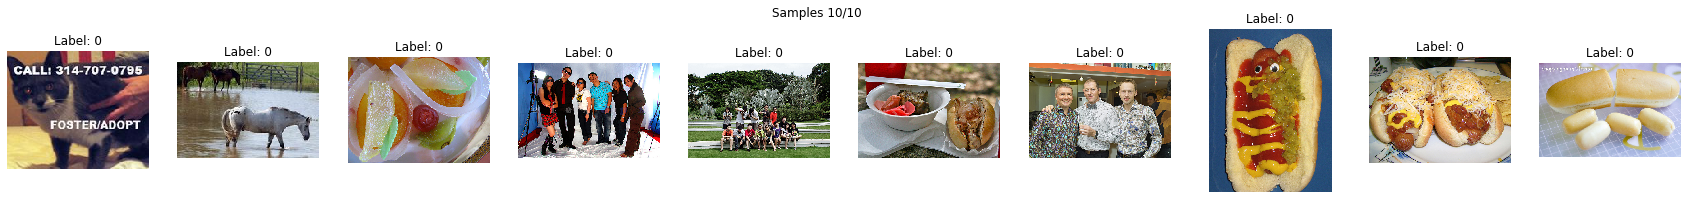

In [20]:
def visualize_samples(dataset, indices, title=None, count=10):
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1, count, i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   
    
orig_dataset = KinderDataset(train_folder)
orig_test_dataset = KinderDataset(test_folder)
indices = np.random.choice(np.arange(len(orig_dataset)), 10, replace=False)

visualize_samples(orig_dataset, indices, "Samples")

In [0]:
tfs = transforms.Compose([
                          transforms.Resize((224, 224)),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                               std=[0.229, 0.224, 0.225])                         
                       ])

data_train = KinderDataset(train_folder, transform = tfs)

data_test = KinderDataset(test_folder, transform = tfs)

In [0]:
batch_size = 64

validation_size = .3

data_size = len(data_train)
split = int(np.floor(validation_size * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[:split], indices[split:]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=val_sampler)

In [0]:
def train_model(model, train_loader, val_loader, loss, optimizer,  scheduler=None, num_epochs=20):
  train_loss_history = []
  train_history = []
  val_loss_histroy = []
  val_histroy = []

  for i_epoch in range(num_epochs):
    model.train()

    train_loss_sum = 0
    correct_samples = 0
    all_samples = 0

    for i_step, (x, y, _) in enumerate(train_loader):
      x_gpu = x.to(device)
      y_gpu = y.to(device)
      prediction = model(x_gpu)
      step_loss = loss(prediction, y_gpu)
      optimizer.zero_grad()
      step_loss.backward()
      optimizer.step()

      y_hat = torch.argmax(prediction, 1)
      correct_samples += float(torch.sum(y_hat == y_gpu))
      all_samples += y.shape[0]
      train_loss_sum += step_loss
    
    train_loss = train_loss_sum / i_step
    train_accuracy = correct_samples / all_samples
    val_loss, val_accuracy = compute_accuracy(model, val_loader, loss)
    if scheduler:
      scheduler.step(val_loss)

    train_loss_history.append(train_loss)
    val_loss_histroy.append(val_loss)
    train_history.append(train_accuracy)
    val_histroy.append(val_accuracy)

    print('Epoch num: %f, Train loss: %f, Val loss: %f, Train accuracy: %f, Validation accuracy: %f' % (i_epoch, train_loss, val_loss, train_accuracy, val_accuracy))
  
  return train_loss_history, val_loss, train_history, val_histroy

def compute_accuracy(model, loader, loss):
  model.eval()

  correct_samples = 0
  all_samples = 0
  loss_sum = 0

  for i_step, (x, y, _) in enumerate(loader):
    x_gpu = x.to(device)
    y_gpu = y.to(device)

    prediction = model(x_gpu)
    y_hat = torch.argmax(prediction, 1)

    loss_val = loss(prediction, y_gpu)
    loss_sum += float(loss_val)

    correct_samples += float(torch.sum(y_hat == y_gpu))
    all_samples += y.shape[0]
    
  avg_loss = loss_sum / i_step
  accuracy = correct_samples / all_samples

  return avg_loss, accuracy

In [0]:
def load_imagenet_classes():
    classes_json = urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json').read()
    classes = json.loads(classes_json)
    return { int(k): v[-1] for k, v in classes.items()}

def visualize_samples(dataset, orig_dataset, model, indices, classes, title=None, count=10):
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        x_gpu = x.to(device)
        pred = model(torch.unsqueeze(x_gpu, 0))
        y_hat = torch.argmax(pred, 1)
        clas = classes[int(y_hat)]
        image, _, _ = orig_dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % clas)
        plt.imshow(image)
        plt.grid(False)
        plt.axis('off')

model = models.resnet18(pretrained=True)
model.type(torch.cuda.FloatTensor)
model.to(device)

model.eval()

classes = load_imagenet_classes()
indices = np.random.choice(np.arange(len(classes)), 10, replace=False)
visualize_samples(data_train, orig_dataset, model, indices, classes) 

In [0]:
model = models.resnet18(pretrained=True)
      
for param in model.parameters():
  param.requires_grad = False
        
old_fc = model.fc
model.fc = nn.Linear(old_fc.in_features, 2)
      
model.type(torch.cuda.FloatTensor)
model.to(device)
      
parameters = model.fc.parameters()
      
loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(parameters, lr=0.01, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2)

In [17]:
train_loss_history, val_loss, train_history, val_histroy = train_model(model, train_loader, val_loader, loss, optimizer, scheduler, 10)

Epoch num: 0.000000, Train loss: 0.693566, Val loss: 0.363237, Train accuracy: 0.923077, Validation accuracy: 0.847936
Epoch num: 1.000000, Train loss: 0.131565, Val loss: 0.034623, Train accuracy: 0.958420, Validation accuracy: 0.989011
Epoch num: 2.000000, Train loss: 0.042154, Val loss: 0.036213, Train accuracy: 0.985447, Validation accuracy: 0.988120
Epoch num: 3.000000, Train loss: 0.016911, Val loss: 0.029334, Train accuracy: 0.994456, Validation accuracy: 0.991090
Epoch num: 4.000000, Train loss: 0.010420, Val loss: 0.028670, Train accuracy: 0.998614, Validation accuracy: 0.992278
Epoch num: 5.000000, Train loss: 0.009645, Val loss: 0.030193, Train accuracy: 0.999307, Validation accuracy: 0.989011
Epoch num: 6.000000, Train loss: 0.008177, Val loss: 0.034041, Train accuracy: 0.999307, Validation accuracy: 0.987526
Epoch num: 7.000000, Train loss: 0.009729, Val loss: 0.029273, Train accuracy: 0.999307, Validation accuracy: 0.992278
Epoch num: 8.000000, Train loss: 0.010743, Val l

In [0]:
def evaluate_model(model, loader):
  predictions = []
  gt = []
  for (x, y, _) in loader:
    x_gpu = x.to(device)
    y_gpu = y.to(device)

    prediction = model(x_gpu)
    y_hat = torch.argmax(prediction, 1)

    predictions.append(int(y_hat))
    gt.append(int(y))

  return np.asarray(predictions), np.asarray(gt)

In [0]:
def binary_classification_metrics(prediction, ground_truth):
    tp = np.sum((prediction == 1) & (ground_truth == 1))
    tn = np.sum((prediction == 0) & (ground_truth == 0))
    fp = np.sum((prediction == 1) & (ground_truth == 0))
    fn = np.sum((prediction == 0) & (ground_truth == 1))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = 2 * precision * recall / (precision + recall)

    return precision, recall, f1, accuracy

In [18]:
test_loader = torch.utils.data.DataLoader(data_test)
prediction, gt = evaluate_model(model, test_loader)
precision, recall, f1, accuracy = binary_classification_metrics(prediction, gt)
print('Precision: %f, Recall: %f, F1: %f, Accuracy: %f' % (precision, recall, f1, accuracy))

Precision: 0.905660, Recall: 0.813559, F1: 0.857143, Accuracy: 0.986766


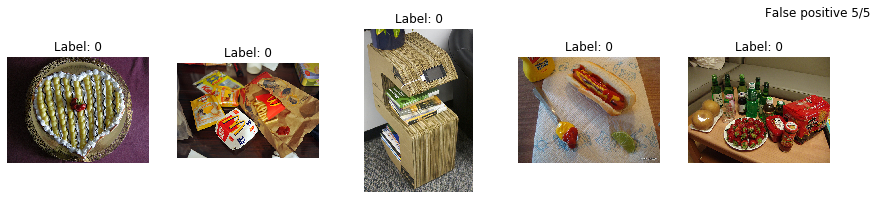

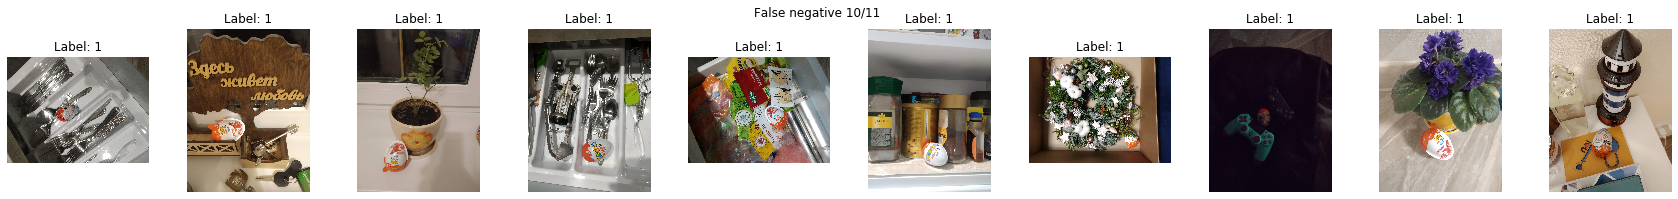

In [21]:
predictions, gt = evaluate_model(model, test_loader)

test_indices = np.array(range(len(data_test)))

false_positive = test_indices[np.nonzero((predictions == 1) & (gt == 0))]
visualize_samples(orig_test_dataset, false_positive, 'False positive')

false_negative = test_indices[np.nonzero((predictions == 0) & (gt == 1))]
visualize_samples(orig_test_dataset, false_negative, 'False negative')

In [0]:
test_loader = torch.utils.data.DataLoader(data_test)

learning_rates = [1e-2, 1e-3]
weight_decay = [1e-2, 1e-3, 1e-4]
schedulers = [(0.5, 2), (0.3, 3), (0.5, 5), (0.1, 2)]

for lr in learning_rates:
  for wd in weight_decay:
    for schdlr in schedulers:
      model = models.resnet18(pretrained=True)
      
      for param in model.parameters():
        param.requires_grad = False
        
      old_fc = model.fc
      model.fc = nn.Linear(old_fc.in_features, 2)
      
      model.type(torch.cuda.FloatTensor)
      model.to(device)
      
      parameters = model.fc.parameters()
      
      loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
      optimizer = optim.Adam(parameters, lr=lr, weight_decay=wd)
      scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=schdlr[0], patience=schdlr[1])

      train_loss_history, val_loss, train_history, val_histroy = train_model(model, train_loader, val_loader, loss, optimizer, scheduler, 10)

      prediction, gt = evaluate_model(model, test_loader)
      precision, recall, f1, accuracy = binary_classification_metrics(prediction, gt)
      print('Learning rate: %f, Weight decay: %f, Factor: %f, Patience: %f' % (lr, wd, schdlr[0], schdlr[1]))
      print('Precision: %f, Recall: %f, F1: %f, Accuracy: %f' % (precision, recall, f1, accuracy))

Epoch num: 0.000000, Train loss: 0.999207, Val loss: 0.441972, Train accuracy: 0.916147, Validation accuracy: 0.956638
Epoch num: 1.000000, Train loss: 0.152097, Val loss: 0.035127, Train accuracy: 0.953569, Validation accuracy: 0.986635
Epoch num: 2.000000, Train loss: 0.052352, Val loss: 0.028198, Train accuracy: 0.979903, Validation accuracy: 0.991387
Epoch num: 3.000000, Train loss: 0.024672, Val loss: 0.028000, Train accuracy: 0.991684, Validation accuracy: 0.991981
Epoch num: 4.000000, Train loss: 0.020907, Val loss: 0.023893, Train accuracy: 0.994456, Validation accuracy: 0.991981
Epoch num: 5.000000, Train loss: 0.020908, Val loss: 0.031375, Train accuracy: 0.995149, Validation accuracy: 0.985744
Epoch num: 6.000000, Train loss: 0.015356, Val loss: 0.022861, Train accuracy: 0.996535, Validation accuracy: 0.992575
Epoch num: 7.000000, Train loss: 0.013748, Val loss: 0.022535, Train accuracy: 0.997228, Validation accuracy: 0.993466
Epoch num: 8.000000, Train loss: 0.013092, Val l